## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical
import librosa
import keras
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import plot_confusion_matrix

## Feautres Extraction

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Dataset/metadata/UrbanSound8K.csv")
df.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [ ]:
label = []
feature = []
# Function to load files and extract feature
def parser(row):
    for i in range(len(df)):
        file_name = '/content/drive/MyDrive/Dataset/audio/fold' + str(df["fold"][i]) + '/' + df["slice_file_name"][i]
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        mels = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)  
        print(mels.shape)      
        feature.append(mels)
        label.append(df["classID"][i])
    return [feature, label]

In [ ]:
temp = parser(df)

In [ ]:
#loading the saved data
X=np.load('/content/drive/MyDrive/X.npy')
Y=np.load('/content/drive/MyDrive/Y.npy')

### Split the Data

In [ ]:
## Splitting the data into 60% unlabeled 10% testing and 30% training
X_train, X_un, y_train, y_un = train_test_split(X, Y, test_size=0.6,random_state=1)
X_t, X_test, y_t, y_test = train_test_split(X_train, y_train, test_size=0.25,random_state=1)

In [ ]:
#since feature extraction is giving 1D array as output, we are reshaping these arrays 

X_t = X_t.reshape(len(X_t), 16, 8)
X_test = X_test.reshape(len(X_test), 16, 8)
X_un= X_un.reshape(len(X_un), 16, 8)

### Create LSTM model

In [ ]:
input_dim = (16, 8)
dropout=0.1
n_classes=10
learning_rate = 0.0001

In [ ]:
#sequential model for training
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=input_dim,dropout=dropout))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(n_classes, activation='softmax'))
opt = Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
#using early stopping with patience 40
callbacks = [ModelCheckpoint('/content/drive/MyDrive/ML_S/base_LSTM_inc_lr.h5', monitor='val_loss', mode='min', save_best_only=True),EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 40,restore_best_weights = True)]

In [ ]:
X__train, X_val, y__train, y_val = train_test_split(X_t, y_t, test_size=0.3,random_state=1) #taking validation set as 30% of training data

### Baseline Train

In [ ]:
#training with batch size 200
history1 = model.fit(X__train, y__train, epochs = 500, batch_size = 200, validation_data = (X_val, y_val),callbacks=callbacks)

Epoch 1/500
10/10 [==============================] - 5s 259ms/step - loss: 2.2705 - accuracy: 0.1404 - val_loss: 2.1654 - val_accuracy: 0.2226
Epoch 2/500
10/10 [==============================] - 2s 202ms/step - loss: 2.1513 - accuracy: 0.2435 - val_loss: 2.0753 - val_accuracy: 0.2952
Epoch 3/500
10/10 [==============================] - 2s 203ms/step - loss: 2.0669 - accuracy: 0.3159 - val_loss: 2.0017 - val_accuracy: 0.3066
Epoch 4/500
10/10 [==============================] - 2s 207ms/step - loss: 1.9856 - accuracy: 0.3112 - val_loss: 1.9416 - val_accuracy: 0.3308
Epoch 5/500
10/10 [==============================] - 2s 203ms/step - loss: 1.9273 - accuracy: 0.3438 - val_loss: 1.8872 - val_accuracy: 0.3626
Epoch 6/500
10/10 [==============================] - 2s 205ms/step - loss: 1.8984 - accuracy: 0.3404 - val_loss: 1.8356 - val_accuracy: 0.3766
Epoch 7/500
10/10 [==============================] - 2s 206ms/step - loss: 1.8383 - accuracy: 0.3711 - val_loss: 1.8022 - val_accuracy: 0.3944

#### Evaluation of baseline LSTM model

In [ ]:
accuracy=model.evaluate(X_test,y_test)

28/28 [==============================] - 1s 19ms/step - loss: 1.1681 - accuracy: 0.6094


### Self Train LSTM

In [ ]:
iteration=1
x_new=[0]*30
s=pd.DataFrame([]) # create table to store entries
iter=[]
labels_tobe_added=[]
val_acc=[]
labeled=[]
unlabeled=[]
train_acc=[]
## stopping condition: 1) when less than 10 samples have prediction probability less than threshold 2)when no unlabeled data is left 3) terminate after 9 iterations of the loop 
while len(x_new)>10 and len(X_un)>0 and iteration<10:
  
  # split the data into training and testing
  X__train, X__val, y__train, y__val = train_test_split(X_t, y_t, test_size=0.3)

  print("labeled at start of iteration:",iteration," is ",len(X__train), "and unlabeled is",len(X_un))
  labeled.append(len(X__train))
  unlabeled.append(len(X_un))

  ## Create the model
  model = Sequential()
  model.add(LSTM(256, return_sequences=True, input_shape=input_dim,dropout=dropout))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(n_classes, activation='softmax'))
  opt = Adam(lr=learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=opt,
  metrics=['accuracy'])
  callbacks = [ModelCheckpoint('/content/drive/MyDrive/self_train_lstm.h5', monitor='val_loss', mode='min', save_best_only=True),EarlyStopping(monitor = 'val_loss',min_delta = 0,patience = 30,restore_best_weights = True)]
  
  ## fit the model
  history = model.fit(X__train, y__train, epochs = 500, batch_size = 200, validation_data = (X__val, y__val), callbacks=callbacks)
  
  accuracy1=model.evaluate(X__val,y__val)
  print("val_accuracy=",accuracy1)
  iter.append(iteration)
  val_acc.append(accuracy1[1]*100)
  accuracy2=model.evaluate(X__train,y__train)
  train_acc.append(accuracy2[1]*100)
  print("train accuracy=",accuracy2)
  
  # use supervised model to predict on unlabeled data
  y_un_pred = model.predict(X_un)
  l = np.argmax(y_un_pred, axis=1)
  l_correct = []
  x_new = []
  y_new = []

  # add only those proxy labels which has probablity of being correct prediction greater than 99%
  for i in range(len(y_un)):
    if y_un_pred[i][l[i]]>=0.99: 
      x_new.append(X_un[i])
      y_new.append(l[i])
      l_correct.append(i)
  y_new2 = to_categorical(y_new, num_classes=10)
  y_new=np.array(y_new2)
  x_new=np.array(x_new)
  if x_new.shape==(0,): break

  # adding the proxy labeled samples to the training data  and deleted those samples in unlabeled set
  X_t = np.append(X_t, x_new, axis=0)
  y_t = np.append(y_t, y_new, axis=0)
  X_un = np.delete(X_un, l_correct, axis = 0)
  y_un = np.delete(y_un, l_correct, axis=0)

  print("unlabeled remaining=",len(X_un)," labels added=",len(x_new))
  labels_tobe_added.append(len(x_new))
  
  iteration=iteration+1

labeled at start of iteration: 1  is  1833 and unlabeled is 5240
Epoch 1/500
10/10 [==============================] - 4s 261ms/step - loss: 2.2586 - accuracy: 0.1413 - val_loss: 2.1833 - val_accuracy: 0.2392
Epoch 2/500
10/10 [==============================] - 2s 199ms/step - loss: 2.1467 - accuracy: 0.2627 - val_loss: 2.0907 - val_accuracy: 0.2684
Epoch 3/500
10/10 [==============================] - 2s 202ms/step - loss: 2.0393 - accuracy: 0.3036 - val_loss: 2.0136 - val_accuracy: 0.3270
Epoch 4/500
10/10 [==============================] - 2s 204ms/step - loss: 1.9706 - accuracy: 0.3472 - val_loss: 1.9490 - val_accuracy: 0.3575
Epoch 5/500
10/10 [==============================] - 2s 197ms/step - loss: 1.9040 - accuracy: 0.3588 - val_loss: 1.9045 - val_accuracy: 0.3893
Epoch 6/500
10/10 [==============================] - 2s 204ms/step - loss: 1.8534 - accuracy: 0.3856 - val_loss: 1.8533 - val_accuracy: 0.4135
Epoch 7/500
10/10 [==============================] - 2s 202ms/step - loss: 1.

In [ ]:
s['Iteration']=iter
s['Training samples']=labeled
s['Unlabeled']=unlabeled
s['labels>threshold']=labels_tobe_added
s['Train Accuracy']=train_acc
s['Validation Accuracy']=val_acc
s

,Iteration,Training samples,Unlabeled,labels>threshold,Train Accuracy,Validation Accuracy
0,1,1833,5240,682,76.868522,62.340969
1,2,2310,4558,187,78.614718,66.801208
2,3,2441,4371,322,84.842277,74.498570
3,4,2667,4049,110,84.851891,72.965878
4,5,2744,3939,83,83.709913,76.020408
5,6,2802,3856,22,82.833689,73.105747
6,7,2817,3834,43,85.090524,74.751657
7,8,2847,3791,30,84.439760,75.429976
8,9,2868,3761,64,86.715484,77.723575


In [ ]:
s.to_csv('/content/drive/MyDrive/ML_S/self_LSTM_base.csv')

#### Evaluation of self trained LSTM model

In [ ]:
model2=keras.models.load_model("/content/drive/MyDrive/self_train_lstm.h5")

In [ ]:
accuracy=model2.evaluate(X_test,y_test)
accuracy=model2.evaluate(X_t,y_t)

82/82 [==============================] - 2s 19ms/step - loss: 0.7592 - accuracy: 0.7514


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

label=[ 'air_conditioner', 'car_horn', 'children_playing','dog_bark', 'drilling', 'engine_idling', 'gun_shot','jackhammer', 'siren', 'street_music']
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), labels)

In [ ]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

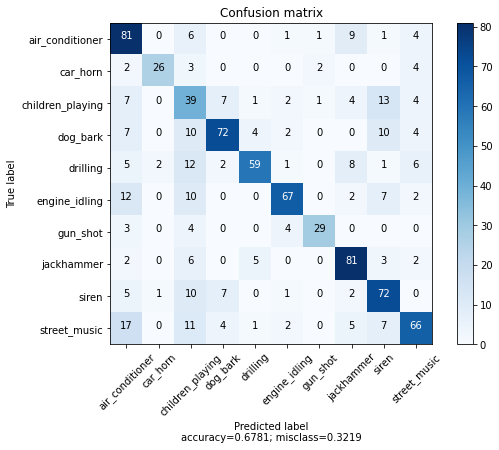

In [ ]:
plot_confusion_matrix(cm, label, normalize=False)